In [1]:
#1. module import
from ast import increment_lineno
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
import os
import pandas as pd
from torchvision.io import read_image

In [2]:
# 2. 딥러닝 모델 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
     DEVICE=torch.device('cuda')
else:
     DEVICE=torch.device('cpu')

print('Using Pytorch version:',torch.__version__,'Device:',DEVICE)

Using Pytorch version: 1.11.0 Device: cuda


In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(csv_file)         # annotation_file을 csv_file로 바꿈
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
        

In [4]:
BATCH_SIZE = 16
EPOCHS = 10

In [5]:
train_data = CustomImageDataset("../train.csv",
                                   ".././Taekwondo/DataSet/train_",
                                   None, None)
test_data = CustomImageDataset("../test.csv",
                               ".././Taekwondo/DataSet/test_",
                               None, None)
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                        batch_size = BATCH_SIZE,
                                        shuffle=True)

# torch.utils.data.DataLoader 에서 DataLoader만 남김                             

X_train: torch.Size([16, 3, 424, 776]) type: torch.ByteTensor
Y_train: torch.Size([16]) type: torch.LongTensor


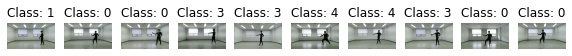

In [6]:
# 5. 데이터 확인하기
for(X_train,Y_train)in train_loader:
    print('X_train:',X_train.size(),'type:', X_train.type())
    print('Y_train:',Y_train.size(),'type:', Y_train.type())
    break

pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)     # 여러 그래프 그리기, 첫숫자 : 행, 둘째 : 열
    plt.axis('off')           # 축없음
    plt.imshow(np.transpose(X_train[i],(1,2,0)))
    plt.title('Class: ' + str(Y_train[i].item()))
# imshow : 이미지 출력

In [7]:
class CNN(nn.Module):                 # nn.Module을 상속받는 Net클래스 생성
    def __init__(self):   
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16,32, 3)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(kernel_size = 2,
                                 stride = 2)
        self.fc1=nn.Linear(8*8*16,64) # (input node수, output node수)
        self.fc2=nn.Linear(64,8)   # 이전 output node수 = 다음 input node수
        
    def forward(self,x):
        # x = self.conv1(x)
        # x = F.relu(x)
        # x = self.pool(x)
        x = self.pool(F.relu(self.conv1(x)))
        # x = self.conv2(x)
        # x = F.relu(x)
        # x = self.pool(x)
        x = self.pool(F.relu(self.conv2(x)))
        # x = self.conv3(x)
        # x = F.relu(x)
        # x = self.pool(x)
        x = self.pool(F.relu(self.conv3(x)))
        # x = self.conv4(x)
        # x = F.relu(x)
        # x = self.pool(x)
        x = self.pool(F.relu(self.conv4(x)))
        
        x = x.view(-1, 2*2*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x,dim=1)
        return x


net = CNN()


In [12]:
model=CNN().to(DEVICE)                  # MLP모델을 기존에 선정한 'DEVICE'에 할당합니다. 
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
# Back Propagation을 이용해 파라미터를 업데이트할 때 이용하는 Optimizer를 정의합니다.
# SGD알고리즘을 이용하며 Learning Rate = 0.01, momentum=0.5로 설정
criterion=nn.CrossEntropyLoss()
# MLP모델의 output값과 계산될 Label값은 Class를 표현하는 원-핫 인코딩 값입니다.
# MLP모델의 output값과 원-핫 인코딩 값과의 Loss는 CrossEntropy를 이용해 계산하기 위해
# criterion은 nn.CrossEntropyLoss() 로 설정. 

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=8, bias=True)
)


In [9]:
def train(model, train_loader, optimizer, log_interval):
    model.train()         # 학습상태로 지정
    for batch_idx,(image, label) in enumerate(train_loader):
        image=image.to(DEVICE).float()
        label=label.to(DEVICE).float()
        optimizer.zero_grad()
        output=model(image).float()
        loss=criterion(output,label).float()
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval==0:
            print("Train Epoch: {}[{}/{}({:.0f}%)]\tTrain Loss: {:.6f}"
                  .format(Epoch,batch_idx * len(image),
                len(train_loader.dataset),100.*batch_idx/len(train_loader),loss.item()))



In [10]:
def evaluate(model,test_loader):
    model.eval()                  # 평가상태로 지정
    test_loss=0
    correct=0
    
    with torch.no_grad():
        for image, label in test_loader:
            image=image.to(DEVICE).float()              # 8과 동일
            label=label.to(DEVICE).float()              # 8과 동일
            output=model(image).float()                 # 8과 동일
            test_loss+=criterion(output,label).item().float()
            prediction = output.max(1,keepdim = True)[1].float()
            # MLP 모델의 output값은 크기가 10인 벡터값입니다. 
            # 계산된 벡터값 내 가장 큰 값인 위치에 대해 해당 위치에 대응하는 클래스로 예측했다고 판단합니다.
            correct += prediction.eq(label.view_as(prediction)).sum().item().float()
            # MLP모델이 최종으로 예측한 클래스 값과 실제 레이블이 의미하는 클래스가 맞으면 correct에 더해 올바르게 예측한 횟수를 저장
                        
    test_loss /= len(test_loader.dataset).float()
    # 현재까지 계산된 test_loss 값을 test_loader내에 존재하는 Mini-Batch 개수(=10)만큼 나눠 평균 Loss값으로 계산.
    test_accuracy=100.*correct / len(test_loader.dataset).float()
    # test_loader 데이터중 얼마나 맞췄는지를 계산해 정확도를 계산합니다.
    return test_loss, test_accuracy



In [11]:
for Epoch in range(1,EPOCHS + 1):
    train(model,train_loader,optimizer,log_interval = 200)
    test_loss, test_accuracy=evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".
        format(Epoch,test_loss,test_accuracy))


RuntimeError: mat1 and mat2 shapes cannot be multiplied (70656x16 and 1024x64)